**Preparing data:** Run the next cells to download and prepare the datasets and util functions.

In [0]:
import sys
download_data = False

if 'google.colab' in sys.modules:
    download_data = True

In [0]:
if download_data:
    !wget --no-cache -O init.py -q https://raw.githubusercontent.com/DaielChom/ann-predict-future-sales/master/init.py
    from init import download_utils, unzip_sales_dataset, dataset_dir
    download_utils(force_download=True)

In [0]:
if download_data:
    !mkdir ./local/datasets/
    !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=19208gOk2e6cpZ9dxtGF5HKHGYWn01VRo' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=19208gOk2e6cpZ9dxtGF5HKHGYWn01VRo" -O local/datasets/sales.zip && rm -rf /tmp/cookies.txt

--2020-05-26 21:50:57--  https://docs.google.com/uc?export=download&confirm=&id=19208gOk2e6cpZ9dxtGF5HKHGYWn01VRo
Resolving docs.google.com (docs.google.com)... 173.194.216.139, 173.194.216.113, 173.194.216.101, ...
Connecting to docs.google.com (docs.google.com)|173.194.216.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0c-5g-docs.googleusercontent.com/docs/securesc/s8l981ob6a6f127hv4qii9tgaevjtqo2/mjeipv1djt29vohtakhfkncbsikdj3hr/1590529800000/02012202667471862451/08662402527372307717Z/19208gOk2e6cpZ9dxtGF5HKHGYWn01VRo?e=download [following]
--2020-05-26 21:50:58--  https://doc-0c-5g-docs.googleusercontent.com/docs/securesc/s8l981ob6a6f127hv4qii9tgaevjtqo2/mjeipv1djt29vohtakhfkncbsikdj3hr/1590529800000/02012202667471862451/08662402527372307717Z/19208gOk2e6cpZ9dxtGF5HKHGYWn01VRo?e=download
Resolving doc-0c-5g-docs.googleusercontent.com (doc-0c-5g-docs.googleusercontent.com)... 172.217.204.132, 2607:f8b0:400c:c15::84
Connectin

In [0]:
if download_data:
    unzip_sales_dataset()

**Libraries**

In [0]:
import random
import numpy as np
import progressbar
import pandas as pd
import matplotlib.pyplot as plt
import local.lib as lib

from sklearn.ensemble import RandomForestRegressor

from init import dataset_dir

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
_, signals = lib.get_base_dataset(dataset_dir)

In [0]:
month_to_predict = 4
look_back = 3

In [9]:
results = {}
summary = []

for signal in progressbar.ProgressBar()(signals):
    results.update({signal:{}})
    
    X_train, y_train, i_train, X_test, y_test, i_test = lib.get_split_signal_data(signal, month_to_predict, 
                                                                              look_back, dataset_dir,
                                                                              reshape=False)
    
    model = RandomForestRegressor(n_estimators=15, max_depth=3, n_jobs=-1)
    model.fit(X_train, y_train)
    
    tr_pred = model.predict(X_train)
    ts_pred = model.predict(X_test)
    
    results[signal].update({"train":tr_pred})
    results[signal].update({"test":ts_pred})
    
    tr_rmse = np.sqrt(((y_train - tr_pred)**2).mean())
    ts_rmse = np.sqrt(((y_test - ts_pred)**2).mean())
    
    summary.append([tr_rmse, ts_rmse])

100% (10734 of 10734) |##################| Elapsed Time: 2:49:44 Time:  2:49:44


In [0]:
summary = pd.DataFrame(summary, columns=["train", "test"], index=signals)

In [11]:
summary.head()

,train,test
2_32,0.478636,0.515603
3_32,0.450244,0.494504
4_32,0.484822,0.597555
5_32,0.631472,0.603298
6_32,0.852363,0.884043


In [18]:
summary.shape

(10734, 2)

Text(0.5, 0, 'rsme')

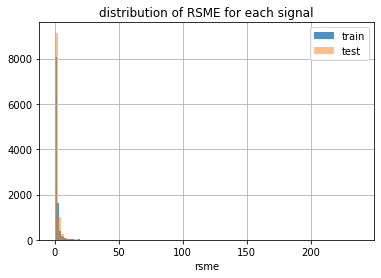

In [14]:
summary.train.hist(bins=100, alpha=0.8, label="train")
summary.test.hist(bins=100, alpha=0.5, label="test")
plt.title("distribution of RSME for each signal")
plt.legend()
plt.xlabel("rsme")

(-3.0, 50.0)

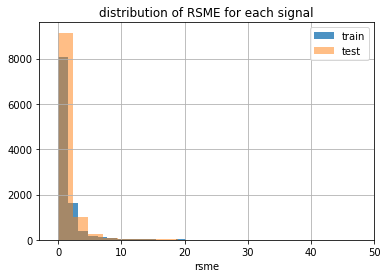

In [17]:
summary.train.hist(bins=100, alpha=0.8, label="train")
summary.test.hist(bins=100, alpha=0.5, label="test")
plt.title("distribution of RSME for each signal")
plt.legend()
plt.xlabel("rsme")
plt.xlim(-3, 50)

In [19]:
summary.mean().to_frame("rsme")

,rsme
train,1.825766
test,1.698879
